# Tensorpacによる位相-振幅カップリング (PAC) 推定
## 周波数間カップリング (CFC) について
近接する神経細胞の集団活動によって生じる電位変化を**電場電位(field potential)** といい，脳波計(EEG), 皮質脳波(ECoG), 脳磁図(MEG)等で計測できる．細胞集団の同期した活動は様々な周波数の振動として計測される．その周波数が属する周波数帯域に応じて，次のような名称がついている．

|  名称  |  周波数帯域  |
| ---- | ---- |
|  Gamma ($\gamma$)  |  > 30 Hz  |
|  Beta ($\beta$) |  12-30 Hz  |
|  Alpha ($\alpha$) |  8-12 Hz  |
|  Theta ($\theta$) |  4-8 Hz  |
|  Delta ($\delta$) |  0.5-4 Hz  |


**周波数間カップリング (cross-frequency coupling; CFC)** とは，異なる周波数帯域の振動の間における相互作用の総称である．次の図は([Jirsa & Müller. *Frontiers in Computational Neuroscience.* 2013](https://www.frontiersin.org/articles/10.3389/fncom.2013.00078/full))からの引用であり，様々なCFCを示している．Aでは振動Xの振幅(amplitude)の2乗(=power)が赤線，位相(phase)の基準が縦点線で示されている．B-FはXの振幅や位相に対してY1-Y5の振幅や位相，周波数が変調されている様子を表している．ここで因果関係は明らかでないので各YからXが変調されている場合もある．GはY5-Y6間での周波数における変調を示している．

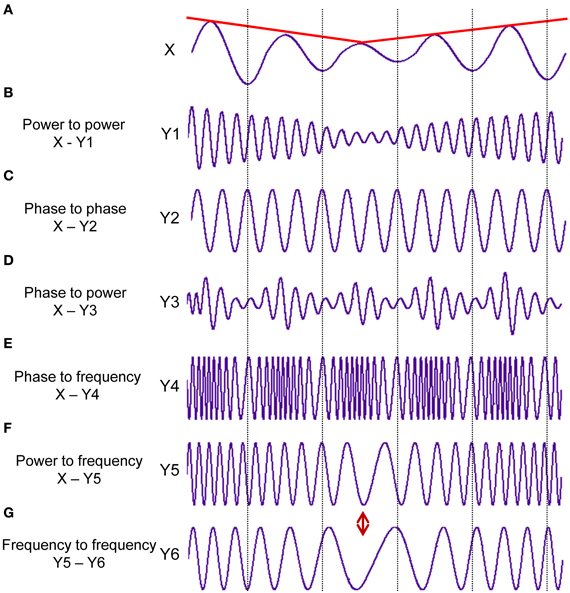

In [1]:
from IPython.display import Image, YouTubeVideo
Image(data='https://www.frontiersin.org/files/Articles/47360/fncom-07-00078-HTML/image_m/fncom-07-00078-g001.jpg', embed=True)

CFCの中でも**位相-振幅カップリング (phase-amplitude coupling; PAC)** が有名であり，上図の中ではDに対応する．PACは主に**低周波の位相**と**高周波の振幅**の変化が同期するという現象である．PACは行動課題やイベント等との相関があり，生理的に妥当な機構がある．低周波の位相は局所的な神経細胞の興奮を反映し，高周波のパワー増加はシナプス活動集団の一般的な増加（広帯域におけるパワー増加），あるいは神経細胞の結合したサブネットワークの選択的活性化（狭帯域におけるパワー増加）のいずれかを反映する ([Canolty & Knight. *Trends in Cognitive Sciences*. 2010](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3359652/))．

CFC，およびPACの動画解説としては以下が分かりやすい．

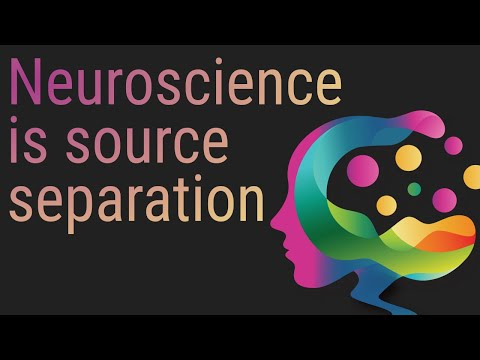

In [2]:
# Neuroscience source separation 3a: Multivariate cross-frequency coupling
YouTubeVideo('pZBq_Im6Xr4')

前置きが長くなったが，この記事ではPACをPythonのライブラリ**tensorpac**を用いて計算する．

## Tensorpac
PAC解析のPythonライブラリは以下の3つがある．

- tensorpac ([Combrisson et al. *PLoS computational biology*. 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008302))：https://github.com/EtienneCmb/tensorpac
- pactools ([Dupre la Tour et al. *PLoS computational biology*. 2017](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005893))：<https://github.com/pactools/pactools>
- pacpy：https://github.com/voytekresearch/pacpy/

中でもtensorpacが一番新しく，tensorにより計算が高速化されている．この記事ではtensorpacのみを使用する．

tensorpacのinstallはpipで可能である．
```
pip install tensorpac
```

以下では[example](https://etiennecmb.github.io/tensorpac/auto_examples/index.html)をベースにtensorpacの基本的な使い方を紹介する．

まず必要なライブラリをimportする．

In [3]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'axes.spines.top': False, 'axes.spines.right': False})

from tensorpac import Pac
from tensorpac.utils import PSD
from tensorpac.signals import pac_signals_tort

### 人工データの生成
[tutorial](https://etiennecmb.github.io/tensorpac/auto_examples/tuto/plot_real_data.html)では([Combrisson et al. 2017](https://www.sciencedirect.com/science/article/abs/pii/S1053811916306607?via%3Dihub))の公開データが用いられているが，以下では[`pac_signals_tort`](https://etiennecmb.github.io/tensorpac/generated/tensorpac.signals.pac_signals_tort.html)関数により人工的に10Hzの位相と100Hzの振幅の間にカップリングがあるデータを生成する．

In [4]:
# Dataset of signals artificially coupled between 10hz and 100hz :
n_epochs = 20    # number of trials
sf = 512.        # sampling frequency
T = 0.5          # one trials time (sec)
n_times = sf * T # number of time points

# Create artificially coupled signals using Tort method :
data, time = pac_signals_tort(f_pha=10, f_amp=100, noise=2, n_epochs=n_epochs, 
                              dpha=10, damp=10, sf=sf, n_times=n_times)
print("data shape (n_epochs, n_times): ", data.shape)

data shape (n_epochs, n_times):  (20, 256)


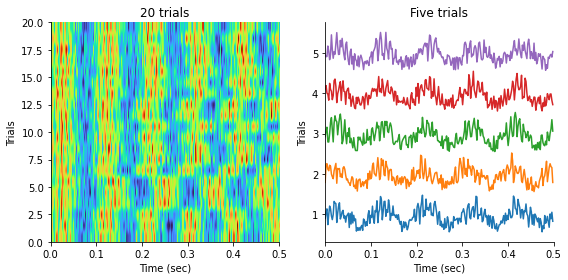

In [5]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
plt.title(str(n_epochs)+" trials")
plt.imshow(data, cmap="turbo", extent=(0,T,0,n_epochs), aspect='auto')
plt.xlim(0, T); plt.xlabel("Time (sec)"); plt.ylabel("Trials")
plt.subplot(1,2,2)
plt.title("Five trials")
for i in range(5):
    plt.plot(time, data[i]*0.2+i+0.75)
plt.xlim(0, T); plt.xlabel("Time (sec)"); plt.ylabel("Trials")
plt.tight_layout()

低周波の位相と高周波の振幅，それぞれの変化が同期していることが分かる（具体的には低周波のピーク付近で高周波の振幅が大きくなっている）．

### パワースペクトル密度 (PSD) 推定
**パワースペクトル密度 (power spectrum density; PSD)** は信号 (`data`)をFFTして各周波数におけるパワーを計算したものである．`PSD`クラスが用意されており，内部実装には[`scipy.signal.periodogram`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.periodogram.html)が用いられている．

In [6]:
psd = PSD(data, sf)

Compute PSD over 20 trials and 256 time points


    Add 95th confidence interval


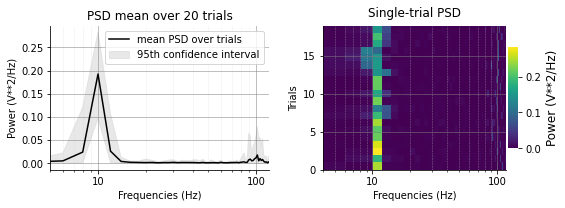

In [7]:
plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
psd.plot(confidence=95, f_min=5, f_max=120, log=True, grid=True, fz_title=12, fz_labels=10)
plt.subplot(1,2,2)
psd.plot_st_psd(f_min=5, f_max=120, log=True, grid=True, fz_title=12, fz_labels=10, fz_cblabel=10)
plt.tight_layout()

### 位相-振幅カップリング (PAC) 推定
PACの計算には[`PAC`](https://etiennecmb.github.io/tensorpac/generated/tensorpac.Pac.html)クラスを用いる． PACの推定には複数の手法があり，`idpac`引数で決めることができる．`idpac`には3つの数のtupleを与える．

- 1桁目：PACを推定するための手法
    1. Mean Vector Length (MVL)
    2. Modulation Index (MI)
    3. Heights Ratio (HR)
    4. ndPAC 
    5. Phase-Locking Value (PLV)
    6. Gaussian Copula PAC (GCPAC)
- 2桁目：サロゲートデータを生成するための手法
    0. No surrogates
    1. Swap phase / amplitude across trials
    2. Swap amplitude time blocks
    3. Time lag
- 3桁目：正規化手法
    0. No normalization
    1. Substract the mean of surrogates
    2. Divide by the mean of surrogates
    3. Substract then divide by the mean of surrogates
    4. Z-score

1桁目の各手法の細かい説明は([Combrisson et al. *PLoS computational biology*. 2020](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008302))を参照．2番目の**サロゲートデータ(surrogate data)** は元データの一部の特性を特定の手法により変形あるいは破壊したもの (cf. [サロゲート法](http://www.simulation-studies.org/research/academicstaffs/nakamura/surrogate_data_method/#:~:text=%E3%82%B5%E3%83%AD%E3%82%B2%E3%83%BC%E3%83%88%E6%B3%95%E3%81%AF%E3%80%81%E3%82%B5%E3%83%AD%E3%82%B2%E3%83%BC%E3%83%88%E3%83%87%E3%83%BC%E3%82%BF,%E3%81%AE%E3%81%8B%E3%81%AF%E5%88%86%E3%81%8B%E3%82%8A%E3%81%BE%E3%81%9B%E3%82%93%E3%80%82))で，例えば1の手法であれば位相と振幅を試行間でswapして生成する．多数のサロゲートデータのそれぞれでPAC値を計算し，サロゲートデータのPACの分布 (surrogate null distribution)を得る．この分布の統計量を用いて3桁目の手法により元データのPACを補正し，さらに統計検定を行って有意差の閾値を計算する．

In [8]:
# Define a Pac object
p = Pac(idpac=(6, 2, 1), f_pha='hres', f_amp='hres')

print("PAC method: ", p.method)
print("Surrogates:", p.str_surro)
print("Normalization:", p.str_norm)

Phase Amplitude Coupling object defined


PAC method:  Gaussian Copula PAC (gcPac)
Surrogates: Swap amplitude time blocks (Bahramisharif et al. 2013)
Normalization: Substract the mean of surrogates


低周波(2-20 Hz)における位相と高周波(60-160 Hz)における振幅を抽出する．

In [9]:
# etract all of the phases and amplitudes
phases = p.filter(sf, data, ftype='phase', n_jobs=1)
amplitudes = p.filter(sf, data, ftype='amplitude', n_jobs=1)

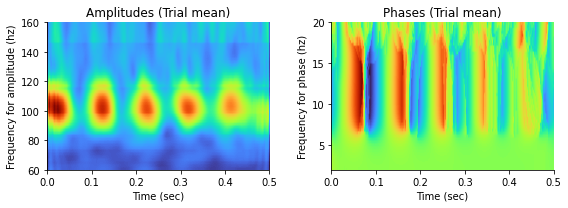

In [10]:
f_amp, f_pha = np.mean(p.f_amp, 1), np.mean(p.f_pha, 1)

plt.figure(figsize=(8, 3))
plt.subplot(1,2,1)
plt.title("Amplitudes (Trial mean)")
plt.imshow(np.mean(amplitudes, 1)[::-1], cmap="turbo", extent=(0,T,f_amp[0],f_amp[-1]), aspect='auto')
plt.xlabel("Time (sec)"); plt.ylabel('Frequency for amplitude (hz)')

plt.subplot(1,2,2)
plt.title("Phases (Trial mean)")
plt.imshow(np.mean(phases, 1)[::-1], cmap="turbo", extent=(0,T,f_pha[0],f_pha[-1]), aspect='auto')
plt.xlabel("Time (sec)"); plt.ylabel('Frequency for phase (hz)')
plt.tight_layout()

### 統計検定とComodulogram
サロゲートデータを計算し，統計検定を行う．

In [11]:
# Filter the data and extract pac
n_perm = 200 # > 1/0.05
xpac = p.filterfit(sf, data, n_perm=n_perm, n_jobs=-1).squeeze()
pval = p.infer_pvalues(p=0.05) # get the corrected p-values

    extract phases (n_pha=50) and amplitudes (n_amps=50)
    true PAC estimation using Gaussian Copula PAC (gcPac)
    compute surrogates (Swap amplitude time blocks (Bahramisharif et al. 2013), 200 permutations, random_state=2958)
    infer p-values at (p=0.05, mcp=maxstat)
    normalize true PAC estimation by surrogates (Substract the mean of surrogates)
    infer p-values at (p=0.05, mcp=maxstat)


`PAC`クラスの`comodulogram`メソッドを用いて結果となるcomodulogramを描画する．

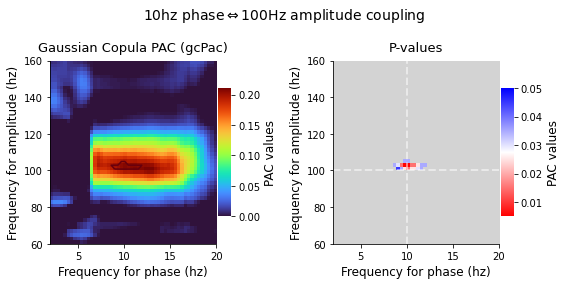

In [12]:
plt.figure(figsize=(8, 4))
plt.suptitle('10hz phase$\Leftrightarrow$100Hz amplitude coupling', fontsize=14)
plt.subplot(1,2,1)
p.comodulogram(xpac.mean(-1), title=p.method,
               cmap='turbo', vmin=0., pvalues=pval, levels=.05)
plt.subplot(1,2,2)
p.comodulogram(pval, title='P-values', cmap='bwr_r', vmin=1. / n_perm,
               vmax=.05, over='lightgray')
plt.axvline(x=10, color="white", linestyle="dashed", linewidth=2, alpha=0.5)
plt.axhline(y=100, color="white", linestyle="dashed", linewidth=2, alpha=0.5)
plt.tight_layout()

生成したデータの通り，10Hzの位相と100Hzの振幅の間のカップリングが推定できていることが分かる．

Tensorpacはこの他にもEvent-related phase-amplitude couplingの推定等，様々な関数が用意されているので，[example](https://etiennecmb.github.io/tensorpac/auto_examples/index.html)を見てみるのがよいだろう．

### その他の参考文献
- https://www.jstage.jst.go.jp/article/jcns/26/12/26_892/_pdf/-char/ja
- https://neuroimage.usc.edu/brainstorm/Tutorials/TutPac
- https://www.mcgill.ca/bic/files/bic/cross_frequency_coupling_soheilasamiee.pdf
- https://mark-kramer.github.io/Case-Studies-Python/07.html
- 
https://github.com/mikexcohen/NeuroscienceSourceSeparation
- https://www.mattcraddock.com/blog/2020/06/12/what-is-intertrial-coherence/
- https://emd.readthedocs.io/en/stable/emd_tutorials/02_spectrum_analysis/emd_tutorial_02_spectrum_03_crossfrequency.html